In [2]:
import numpy as np
import k3d
import cv2
import open3d as o3d
import PIL.Image
import IPython.display

In [3]:
def load_lidar_data(bin_path):
    """Load LiDAR point cloud from a .bin file."""
    lidar_data = np.fromfile(bin_path, dtype=np.float32)
    lidar_data = lidar_data.reshape(-1, 4)  # 6 fields per point (x, y, z, intensity, ring, timestamp)
    return lidar_data

def visualize_lidar_k3d(points):
    """Visualize LiDAR point cloud using k3d."""
    plot = k3d.plot()
    
    # Extract x, y, z
    positions = points[:, :3].astype(np.float32)

    # Create k3d point cloud object
    point_cloud = k3d.points(positions, point_size=0.1)

    plot += point_cloud
    plot.display()


In [4]:
lidar_file = "01545.bin"

points = load_lidar_data(lidar_file)
print(f"Loaded {points.shape[0]} points")

# Call visualization
visualize_lidar_k3d(points)

Loaded 182248 points


Output()

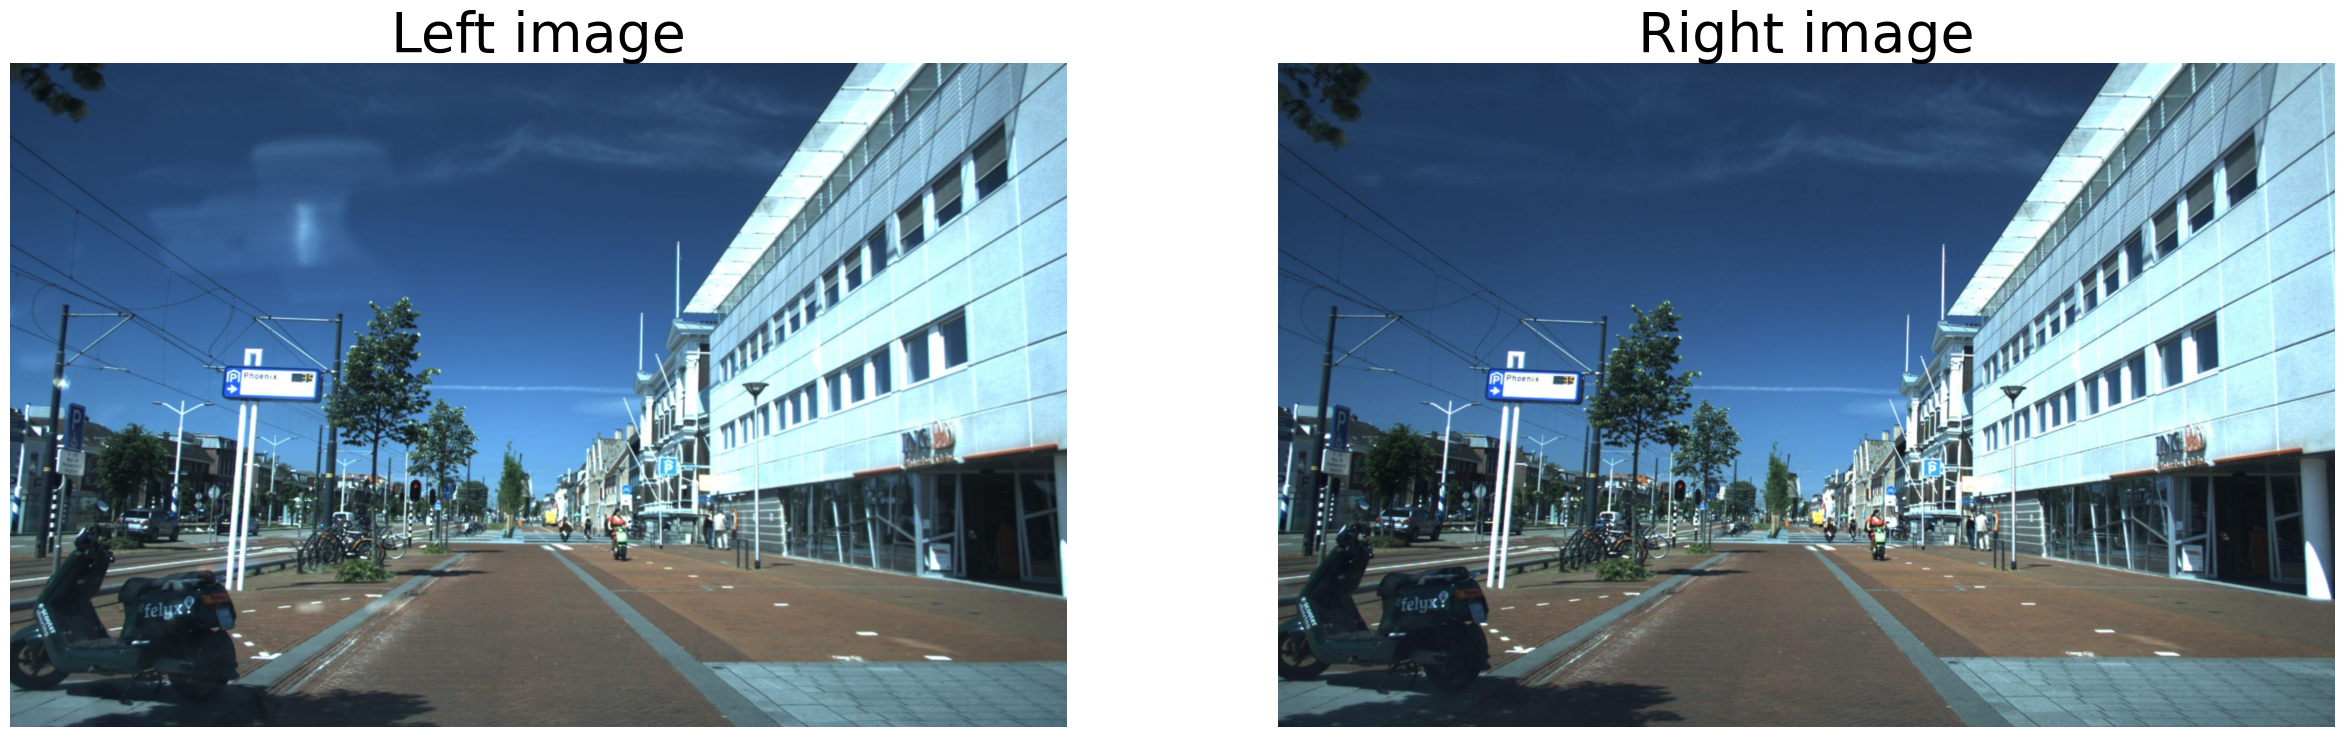

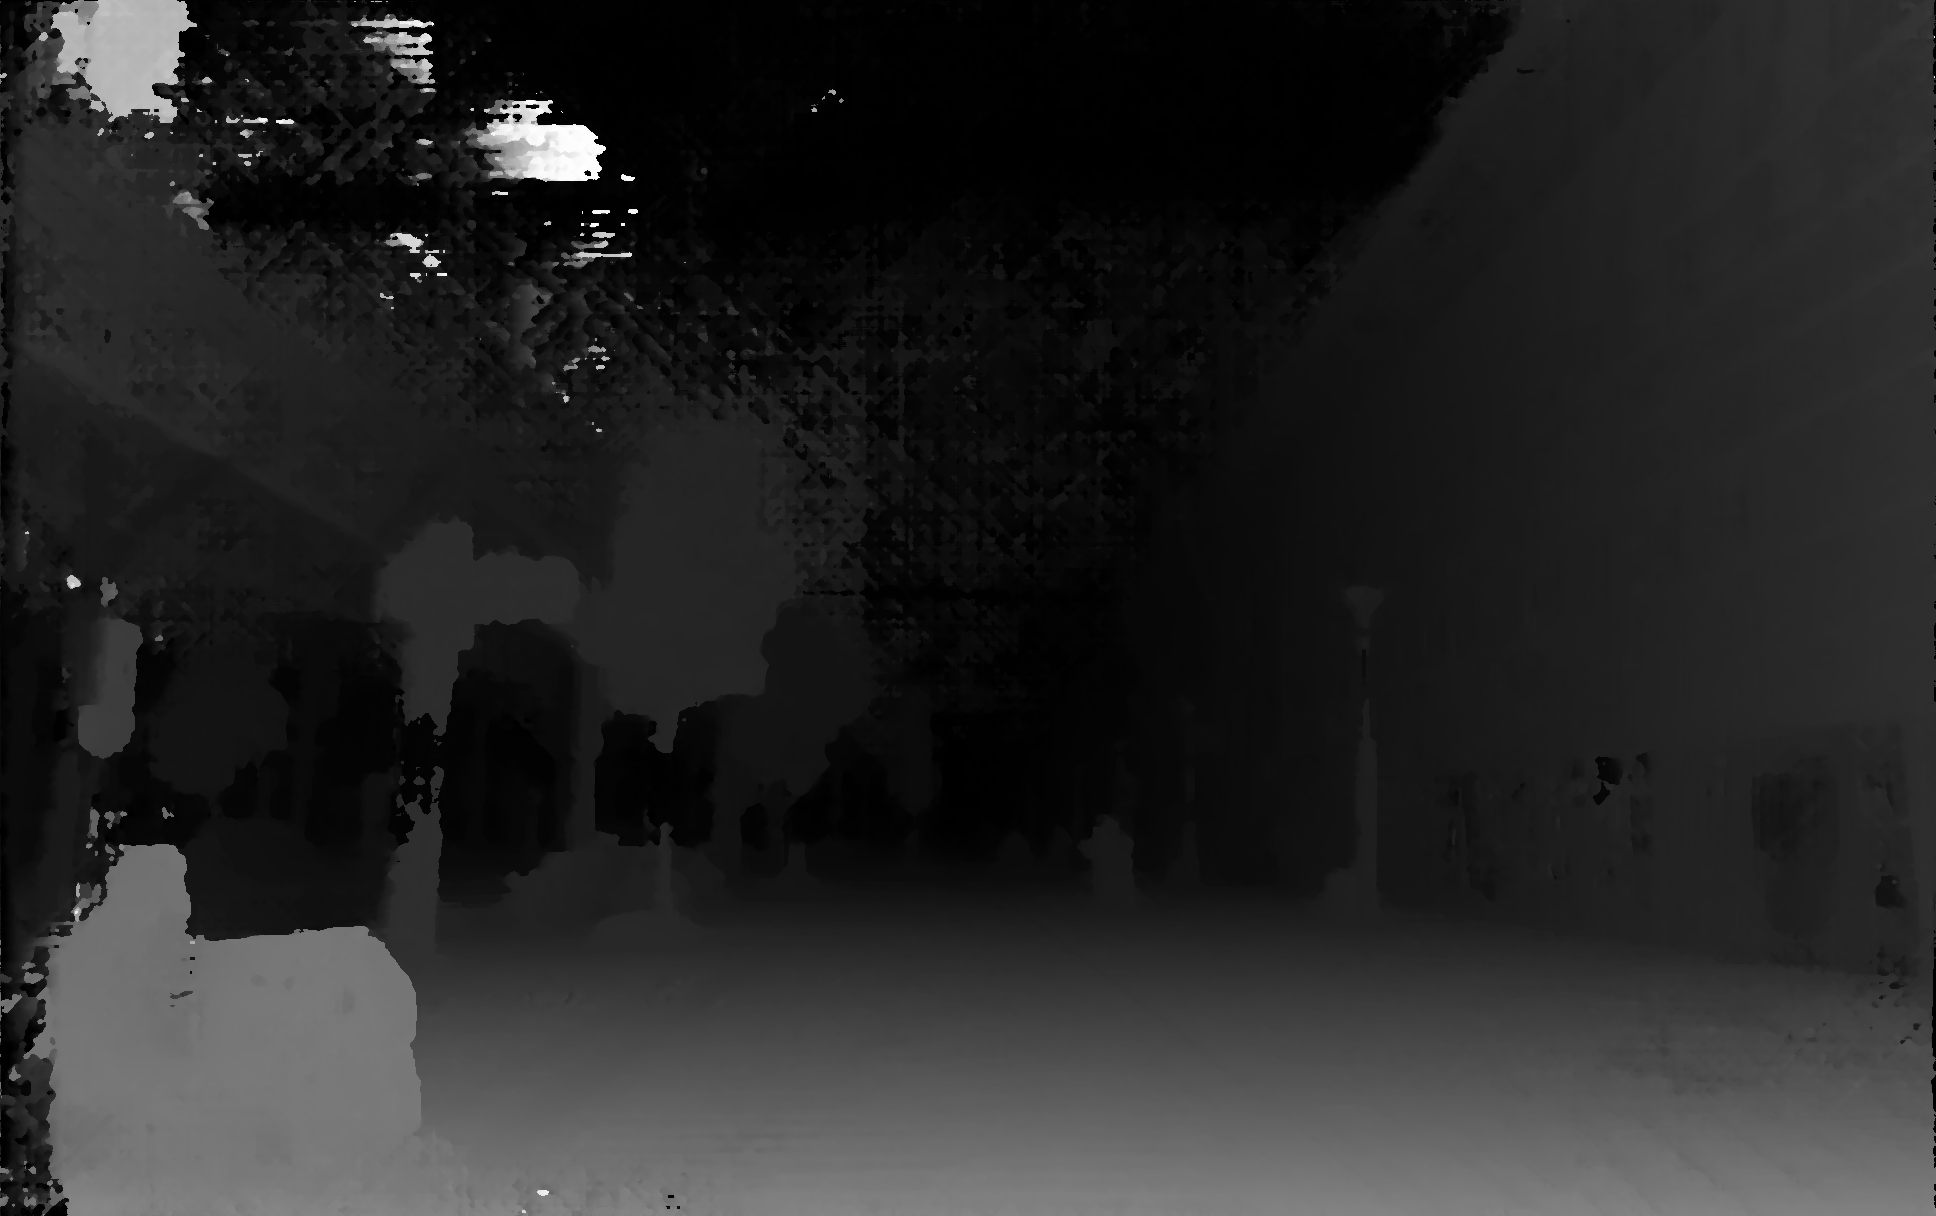

In [5]:
left_img = cv2.imread("01545_left.jpeg", cv2.IMREAD_UNCHANGED)
right_img = cv2.imread("01545_right.jpeg", cv2.IMREAD_UNCHANGED)
disparity_map = cv2.imread("01545.tiff", cv2.IMREAD_UNCHANGED).astype(np.float32)

def showimage(a):
    """Show an image in a Jupyter Notebook cell.
    Expects gray or BGR input (OpenCV default)."""
    # Convert BGR to RGB if needed
    if len(a.shape) > 2 and a.shape[2] == 3:
        a = a[..., ::-1]  # BGR -> RGB
    image = PIL.Image.fromarray(a)
    IPython.display.display(image)  # Display in notebook

# Show left and right image side-by-side.
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(30,30), sharey=True)
axes[0].imshow(left_img[:,:,::-1])
axes[1].imshow(right_img[:,:,::-1])
axes[0].set_title("Left image", fontsize=40)
axes[1].set_title("Right image", fontsize=40)
axes[0].axis('off')
axes[1].axis('off')
plt.show()


# Apply the same normalization as the provided example
normalization_factor = 2
disparity_normalized_uint8 = (disparity_map * normalization_factor).astype(np.uint8)

# Show the disparity image
showimage(disparity_normalized_uint8)


In [6]:
def extract_projection_matrix(file_path):
    right_projection_matrix = None
    
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("P3:"):  # Look for P3 matrix
                values = list(map(float, line.split()[1:]))  # Extract values after "P3:"
                right_projection_matrix = np.array(values).reshape(3, 4)  # Reshape to 3x4 matrix
                break  # Stop reading once P3 is found

    return right_projection_matrix

# Example usage
# file_path = "View_of_Delft_dataset_PUBLIC/view_of_delft_PUBLIC/lidar/training/calib/01545.txt"
file_path = "01545.txt"  
right_projection_matrix = extract_projection_matrix(file_path)
right_projection_matrix[0,3] = -330.2998   # Public VoD version does not contain T_x so we add it manually.


print(right_projection_matrix)

[[ 1.49546864e+03  0.00000000e+00  9.61272442e+02 -3.30299800e+02]
 [ 0.00000000e+00  1.49546864e+03  6.24895920e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]


In [7]:



def rgb_to_int(rgb_colors):
    """
    rgb_colors: np.array of size Nx3
    return: np.array of size N
    """
    # Avoid overflow issues with uint8.
    rgb_colors = rgb_colors.astype(np.uint32).T
    int_colors = (rgb_colors[0] << 16) + (rgb_colors[1] << 8) + rgb_colors[2]
    return int_colors

def bgr_to_int(bgr_colors):
    """
    bgr_colors: np.array of size Nx3
    return: np.array of size N
    """
    return rgb_to_int(bgr_colors[:, ::-1])

def compute_3D_from_disparity(right_projection_matrix, disparity_img):
    """
    return: xyz_img (height x width x 3) array that contains the xyz position
        for each pixel in the image or `np.nan`.
    """
    height, width = disparity_img.shape
    xyz_img = np.zeros((height, width, 3))
    
    f = right_projection_matrix[0, 0]
    c_x = right_projection_matrix[0, 2]
    c_y = right_projection_matrix[1, 2]
    T_x = right_projection_matrix[0, 3]
    
    no_occlusions = (disparity_img > 0)
    depth_img = np.full_like(disparity_img, np.nan, dtype=np.float32)
    depth_img[no_occlusions] = (-T_x) / disparity_img[no_occlusions]
    
    u, v = np.meshgrid(np.arange(width), np.arange(height))
    
    # Camera frame
    X_cam = (u - c_x) * depth_img / f
    Y_cam = (v - c_y) * depth_img / f
    Z_cam = depth_img
    
    # Vehicle frame
    X_vehicle = Z_cam
    Y_vehicle = -X_cam
    Z_vehicle = -Y_cam
    
    # xyz_img = np.dstack((X_cam, Y_cam, Z_cam))
    xyz_img = np.dstack((X_vehicle, Y_vehicle, Z_vehicle))
    
    return xyz_img

xyz_img = compute_3D_from_disparity(right_projection_matrix, disparity_map)

In [8]:
plot = k3d.plot(camera_auto_fit=False, axes_helper=0.0)

left_img_colors = bgr_to_int(left_img[:500, :1000].reshape(-1,3))

plot += k3d.points(positions=xyz_img[:500, :1000].reshape(-1,3).astype(np.float32), point_size=0.025, colors=left_img_colors)
# plot.camera = [0, 0, 0, 0, 0, 15, 0, -1.0, 0]
plot.camera = [0, 0, 0, 15, 0, 0, 0, 0, 1.0]

plot.display()

Output()

In [ ]:
# Transform Disparity Point Cloud from Camera to LiDAR Frame

# Load transformations
T_cam_vehicle = None
T_lidar_vehicle = None

T_vehicle_lidar = np.linalg.inv(T_lidar_vehicle)
T_cam_lidar = T_vehicle_lidar @ T_cam_vehicle
T_lidar_cam = np.linalg.inv(T_cam_lidar)

points_disp_cam = xyz_img.reshape(-1, 3)

# Convert to homogeneous coordinates and transform to LiDAR frame
ones = np.ones((points_disp_cam.shape[0], 1))
disparity_points_camera_hom = np.hstack([points_disp_cam, ones])
disparity_points_lidar_hom = (T_lidar_cam @ disparity_points_camera_hom.T).T
points_from_disparity = disparity_points_lidar_hom[:, :3]


In [ ]:
# Filter Point Clouds in LiDAR Frame (90° FOV and <= 20m Forward)

H_FOV = 45.0
MAX_DIST = 20.0

# For disparity-derived points:
x_disp, y_disp, z_disp = points_from_disparity[:,0], points_from_disparity[:,1], points_from_disparity[:,2]
angles_disp = np.degrees(np.arctan2(y_disp, x_disp))
mask_disp = (x_disp >= 0) & (x_disp <= MAX_DIST) & (np.abs(angles_disp) <= H_FOV)
disparity_points_filtered = points_from_disparity[mask_disp]

# For LiDAR points:
points_lidar = points[:, :3]
x_lidar, y_lidar, z_lidar = points_lidar[:,0], points_lidar[:,1], points_lidar[:,2]
angles_lidar = np.degrees(np.arctan2(y_lidar, x_lidar))
mask_lidar = (x_lidar >= 0) & (x_lidar <= MAX_DIST) & (np.abs(angles_lidar) <= H_FOV)
lidar_points_filtered = points_lidar[mask_lidar]

In [ ]:
# Convert filtered point clouds to Open3D pointcloud objects
pcd_disp = o3d.geometry.PointCloud()
pcd_disp.points = o3d.utility.Vector3dVector(disparity_points_filtered)
pcd_lidar = o3d.geometry.PointCloud()
pcd_lidar.points = o3d.utility.Vector3dVector(lidar_points_filtered)

# Remove NaN and inf
points_disp_array = np.asarray(pcd_disp.points)
points_lidar_array = np.asarray(pcd_lidar.points)
mask_disp_finite = np.isfinite(points_disp_array).all(axis=1)
mask_lidar_finite = np.isfinite(points_lidar_array).all(axis=1)
pcd_disp.points = o3d.utility.Vector3dVector(points_disp_array[mask_disp_finite])
pcd_lidar.points = o3d.utility.Vector3dVector(points_lidar_array[mask_lidar_finite])

# Remove outliers
pcd_disp, ind_disp = pcd_disp.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
pcd_disp = pcd_disp.select_by_index(ind_disp)
pcd_lidar, ind_lidar = pcd_lidar.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
pcd_lidar = pcd_lidar.select_by_index(ind_lidar)

# Compute Hausdorff distance BEFORE ICP
distances_before_1 = pcd_disp.compute_point_cloud_distance(pcd_lidar)
distances_before_2 = pcd_lidar.compute_point_cloud_distance(pcd_disp)
hausdorff_before = max(max(distances_before_1), max(distances_before_2))
print(f"Hausdorff distance before ICP: {hausdorff_before:.3f} m")

# Apply ICP registration
distance_threshold = 0.5  # meters
initial_transform = np.eye(4)
result_icp = o3d.pipelines.registration.registration_icp(
    pcd_disp, pcd_lidar, distance_threshold, initial_transform,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print("ICP converged:", result_icp.is_converged)
print("ICP RMSE:", result_icp.inlier_rmse)

# Transform disparity point cloud using ICP result
pcd_disp_aligned = pcd_disp.transform(result_icp.transformation)

# Compute Hausdorff distance AFTER ICP
distances_after_1 = pcd_disp.compute_point_cloud_distance(pcd_lidar)
distances_after_2 = pcd_lidar.compute_point_cloud_distance(pcd_disp)
hausdorff_after = max(max(distances_after_1), max(distances_after_2))
print(f"Hausdorff distance after ICP: {hausdorff_after:.3f} m")

# Visualize aligned point clouds using Open3D
o3d.visualization.draw_geometries([pcd_disp, pcd_lidar])

Hausdorff Distance before alignment: 9.182471107030645
Hausdorff Distance after alignment: 9.210642989247962


In [ ]:
# from scipy.spatial import distance

# def normalize_point_cloud(pc):
#     # Remove mean and scale by standard deviation
#     pc -= np.mean(pc, axis=0)
#     pc /= np.std(pc, axis=0)
#     return pc

# # Reshape both point clouds into N x 3 format
# points_from_disparity = xyz_img.reshape(-1, 3)
# points_from_lidar = points[:, :3]

# # Normalize both point clouds
# points_from_disparity = normalize_point_cloud(points_from_disparity)
# points_from_lidar = normalize_point_cloud(points_from_lidar)

# # Remove NaN values from disparity point cloud
# mask = ~np.isnan(points_from_disparity).any(axis=1)
# points_from_disparity = points_from_disparity[mask]

# # Compute Hausdorff distance before ICP alignment
# hausdorff_dist = max(
#     distance.directed_hausdorff(points_from_disparity, points_from_lidar)[0],
#     distance.directed_hausdorff(points_from_lidar, points_from_disparity)[0]
# )

# print(f"Hausdorff Distance before alignment: {hausdorff_dist}")

# # Convert numpy arrays to Open3D pointclouds
# pcd_disparity = o3d.geometry.PointCloud()
# pcd_disparity.points = o3d.utility.Vector3dVector(points_from_disparity)

# pcd_lidar = o3d.geometry.PointCloud()
# pcd_lidar.points = o3d.utility.Vector3dVector(points_from_lidar)

# # # Remove outliers
# # pcd_disparity, _ = pcd_disparity.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
# # pcd_lidar, _ = pcd_lidar.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

# # Apply ICP alignment
# threshold = 0.02
# transformation = o3d.pipelines.registration.registration_icp(
#     pcd_disparity, pcd_lidar, threshold,
#     estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint()
# )

# # Apply transformation to disparity pointcloud
# pcd_disparity.transform(transformation.transformation)

# # Compute Hausdorff distance after ICP alignment
# hausdorff_dist = max(
#     distance.directed_hausdorff(np.asarray(pcd_disparity.points), np.asarray(pcd_lidar.points))[0],
#     distance.directed_hausdorff(np.asarray(pcd_lidar.points), np.asarray(pcd_disparity.points))[0]
# )

# print(f"Hausdorff Distance after alignment: {hausdorff_dist}")

In [17]:
import open3d as o3d

# Convert filtered NumPy arrays to Open3D point cloud objects
pcd_disp = o3d.geometry.PointCloud()
pcd_disp.points = o3d.utility.Vector3dVector(points_disp_lidar_filt)
pcd_lidar = o3d.geometry.PointCloud()
pcd_lidar.points = o3d.utility.Vector3dVector(points_lidar_filt)

# Remove any NaN or infinite values just in case (filter rows where any coordinate is non-finite)
points_disp_array = np.asarray(pcd_disp.points)
points_lidar_array = np.asarray(pcd_lidar.points)
mask_disp_finite = np.isfinite(points_disp_array).all(axis=1)
mask_lidar_finite = np.isfinite(points_lidar_array).all(axis=1)
pcd_disp.points = o3d.utility.Vector3dVector(points_disp_array[mask_disp_finite])
pcd_lidar.points = o3d.utility.Vector3dVector(points_lidar_array[mask_lidar_finite])

# Statistical outlier removal to drop noise points
pcd_disp, ind1 = pcd_disp.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
pcd_disp = pcd_disp.select_by_index(ind1)  # keep inliers
pcd_lidar, ind2 = pcd_lidar.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
pcd_lidar = pcd_lidar.select_by_index(ind2)

# Perform ICP registration (Point-to-Point)
distance_threshold = 0.5  # max correspondence distance (in meters)
initial_transform = np.eye(4)  # initial guess (identity, since clouds are roughly aligned in LiDAR frame)

result_icp = o3d.pipelines.registration.registration_icp(
    pcd_disp, pcd_lidar, distance_threshold, initial_transform,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())

print("ICP converged:", result_icp.is_converged)
print("ICP rmse:", result_icp.inlier_rmse)
T_icp = result_icp.transformation  # 4x4 transformation matrix from disparity (source) to LiDAR (target)

# Apply the ICP transformation to the disparity point cloud for alignment
pcd_disp_aligned = pcd_disp.transform(T_icp)

# Compute Hausdorff distance before and after ICP
# (Hausdorff distance = max of nearest-neighbor distances between sets&#8203;:contentReference[oaicite:4]{index=4})
# Before ICP (using extrinsic alignment only):
distances_before_1 = pcd_disp.compute_point_cloud_distance(pcd_lidar)  # dist from each disp point to lidar cloud
distances_before_2 = pcd_lidar.compute_point_cloud_distance(pcd_disp)  # dist from each lidar point to disp cloud
hausdorff_before = max(max(distances_before_1), max(distances_before_2))

# After ICP (using aligned disparity cloud):
distances_after_1 = pcd_disp_aligned.compute_point_cloud_distance(pcd_lidar)
distances_after_2 = pcd_lidar.compute_point_cloud_distance(pcd_disp_aligned)
hausdorff_after = max(max(distances_after_1), max(distances_after_2))

print(f"Hausdorff distance before ICP: {hausdorff_before:.3f} m")
print(f"Hausdorff distance after ICP:  {hausdorff_after:.3f} m")


NameError: name 'points_disp_lidar_filt' is not defined

In [10]:
# Visualize both point clouds after alignment
o3d.visualization.draw_geometries([pcd_disparity, pcd_lidar])

**Apply PointPillars on combined pointcloud**

In [11]:
pcd_disparity.tofile("data/kitti/training/velodyne/00001.bin")


AttributeError: 'open3d.cpu.pybind.geometry.PointCloud' object has no attribute 'tofile'

In [13]:
# This executes shell script to run PointPillars inference
!python demo/pcd_demo.py demo/00001.bin \
    configs/pointpillars/hv_pointpillars_secfpn_6x8_160e_kitti-3d-3class.py \
    work_dirs/pointpillars/latest.pth

python: can't open file 'demo/pcd_demo.py': [Errno 2] No such file or directory


In [14]:
import pickle

# Load PointPillars results
with open('results.pkl', 'rb') as f:
    pointpillars_bboxes = pickle.load(f)


FileNotFoundError: [Errno 2] No such file or directory: 'results.pkl'

In [15]:
plot = k3d.plot()
positions = np.asarray(pcd_disparity.points)
point_cloud = k3d.points(positions, point_size=0.1)
plot += point_cloud

# Draw fused boxes
for bbox in pointpillars_bboxes:
    x, y, z, w, l, h, heading = bbox
    bbox = k3d.bounding_box(bounds=[x-w/2, y-l/2, z-h/2, x+w/2, y+l/2, z+h/2])
    plot += bbox

plot.display()


/home/marcin/anaconda3/envs/UNION-Env/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


NameError: name 'pointpillars_bboxes' is not defined

In [16]:
%history

import numpy as np
import k3d
import cv2
import open3d as o3d
import PIL.Image
import IPython.display
import numpy as np
import k3d
import cv2
import open3d as o3d
import PIL.Image
import IPython.display
def load_lidar_data(bin_path):
    """Load LiDAR point cloud from a .bin file."""
    lidar_data = np.fromfile(bin_path, dtype=np.float32)
    lidar_data = lidar_data.reshape(-1, 4)  # 6 fields per point (x, y, z, intensity, ring, timestamp)
    return lidar_data

def visualize_lidar_k3d(points):
    """Visualize LiDAR point cloud using k3d."""
    plot = k3d.plot()
    
    # Extract x, y, z
    positions = points[:, :3].astype(np.float32)

    # Create k3d point cloud object
    point_cloud = k3d.points(positions, point_size=0.1)

    plot += point_cloud
    plot.display()
lidar_file = "01545.bin"

points = load_lidar_data(lidar_file)
print(f"Loaded {points.shape[0]} points")

# Call visualization
visualize_lidar_k3d(points)
left_img = cv2.imread("01545_left.jpeg", cv2.IMREAD_UNCHANG